In [2]:
import numpy as np
from math import floor
import tau.data_utils as du
import tau.train_utils as tu
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import csv
import os
import shutil
import re
from tqdm import tqdm_notebook as tqdm
import gc

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Config
data_dir = 'data/cifar_data/'
train_dir = 'data/train/'
valid_dir = 'data/valid/'
test_dir = 'data/test/'
has_header = True
data_file = 'trainLabels.csv'
train_file = 'train_labels.csv'
valid_file = 'valid_labels.csv'

In [4]:
# Mean/std stats from Jeremy Howard's CIFAR-10 notebook.
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)
stats = {'mean' : np.array([ 0.4914 ,  0.48216,  0.44653]), 'std' : np.array([ 0.24703,  0.24349,  0.26159])}
data_path = {'train' : train_dir,
            'valid' : valid_dir,
            'test' : test_dir}
csvfile = {'train' : train_file,
          'valid' : valid_file,
          'test' : None}
shuffle = {'train' :  True,
          'valid' : False,
          'test' : False}
max_read = {'train' : 1286,
           'valid' : 64,
           'test' : 0}
img_size = 32
batch_size = 32
num_workers = 0

In [5]:
# Read data
data_transforms = {'train' : transforms.Compose([
                        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(stats['mean'], stats['std'])]),
                  'valid' : transforms.Compose([transforms.ToTensor(),
                                               transforms.Normalize(stats['mean'], stats['std'])]),
                  'test' : transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(stats['mean'], stats['std'])])}
image_datasets = {x : du.SingleLabelImages(x, data_path[x], csvfile[x], classes, '.png', 
                                    data_transforms[x], max_read[x]) for x in ['train', 'valid', 'test']}
image_loaders = {x : DataLoader(image_datasets[x], shuffle=shuffle[x], batch_size=batch_size, 
                                num_workers=num_workers) for x in ['train', 'valid', 'test']}

Read 1286 train images.
Read 64 valid images.
Read 0 test images.


In [6]:
sample = image_datasets['train'].__getitem__(50)

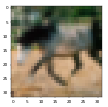

Label: horse


In [7]:
# Returns an image in numpy array form with shape (H, W, C)
def DenormalizeImage(img_tensor, mean, std):
    return np.clip(img_tensor.numpy().transpose((1,2,0))*std + mean, 0.0, 1.0)
plt.rcParams['figure.dpi'] = 30
_ = plt.imshow(DenormalizeImage(sample['image'], stats['mean'], stats['std']))
plt.show()
print('Label: {}'.format(classes[sample['label']]))

In [8]:
model = models.resnet18(pretrained=False)
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
#optimizer = optim.Adam(model.parameters())
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
trainer = tu.Trainer(device, model, criterion, optimizer, '')
trainer.Train(image_loaders)

TypeError: __init__() missing 1 required positional argument: 'model_path'

In [10]:
trainer.printModules(False)

NameError: name 'trainer' is not defined

In [17]:
model = tu.NNModel(device, 'resnet34', 'sgd', 'cross_entropy', 10, image_loaders, pre_trained=True)
model.printModules(False)
#model.freezeParams(freeze_modules=['layer3.conv1'])
#nn_model.exploreLR()
#model = models.resnet18(pretrained=False)
# for name, module in model.named_modules():
#     if (name == 'layer1'):
#         for p in module.parameters():
#             p.requires_grad = False
# for n, p in nn_model.model.named_parameters():
#     print(n, p.requires_grad)
#trainer = model_tools.Trainer(device, nn_model.model, nn_model.criterion, nn_model.optimizer, nn_model.scheduler, '')
#stats = trainer.train(image_loaders)


Module: conv1
Module: bn1
Module: relu
Module: maxpool
Module: layer1
        |_ 0
        |___ conv1
        |___ bn1
        |___ relu
        |___ conv2
        |___ bn2
        |_ 1
        |___ conv1
        |___ bn1
        |___ relu
        |___ conv2
        |___ bn2
        |_ 2
        |___ conv1
        |___ bn1
        |___ relu
        |___ conv2
        |___ bn2
Module: layer2
        |_ 0
        |___ conv1
        |___ bn1
        |___ relu
        |___ conv2
        |___ bn2
        |___ downsample
...... 0
...... 1
        |_ 1
        |___ conv1
        |___ bn1
        |___ relu
        |___ conv2
        |___ bn2
        |_ 2
        |___ conv1
        |___ bn1
        |___ relu
        |___ conv2
        |___ bn2
        |_ 3
        |___ conv1
        |___ bn1
        |___ relu
        |___ conv2
        |___ bn2
Module: layer3
        |_ 0
        |___ conv1
        |___ bn1
        |___ relu
        |___ conv2
        |___ bn2
        |___ downsample
...... 0
.

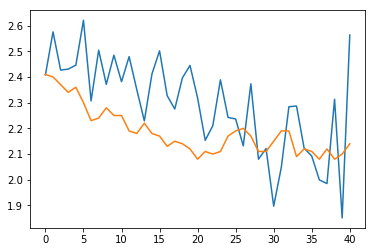

In [8]:
plt.plot(np.asarray(stats['train_loss']))
plt.plot(np.asarray(stats['valid_loss']))

In [ ]:

def RecordLoss(mode, loss_dict):
    with open('loss_history.csv', mode) as f:
        fieldnames = ['iter', 'train_loss', 'val_loss']
        writer = csv.writer(f, lineterminator='\n')
        if (mode == 'w'):
            writer.writerow(fieldnames)
        for num_iter, loss in loss_dict.items():
            writer.writerow([num_iter, loss[0], loss[1]])
            
def EvalStats(model, criterion, image_loader, num_items=1, req_stats=['loss']):
    num_updates = 0
    loss_stat= 0.0
    stats = {}
    torch.set_grad_enabled(False)
    for sample in iter(image_loader):
        inputs, labels = sample['image'].to(device), sample['label'].long().to(device)
        outputs = model(inputs)
        if ('loss' in req_stats):
            loss = criterion(outputs, labels)
            loss_stat += loss.item()
        num_updates += 1
    torch.set_grad_enabled(True)
    if ('loss' in req_stats):
        if (num_updates == 0):
            loss_stat = 0.0
        else:
            loss_stat = round(loss_stat/num_updates*num_items, 2)
        stats.update({'loss' : loss_stat})
    return stats
    
    
def TrainModel(model, criterion, optimizer, model_path, num_epochs=5, stat_freq=1, checkpoint_freq=500):
    progress_bar = tqdm(total=num_epochs)
    loss_history = {'train' : [],
                   'valid' : []}
    loss_dict = {}
    # set best_val_loss as loss on the valid set with initial state of the model
    stats = EvalStats(model, criterion, image_loaders['valid'], num_items=1, req_stats=['loss'])
    best_val_loss = stats['loss']
    
    # Train the model
    torch.set_grad_enabled(True)
    num_updates = 0
    num_iter = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(image_loaders['train'], 0):
            num_iter += 1
            if (i%5 == 4):
                progress_bar.set_description('e {} i {}'.format(epoch + 1, i + 1))
            inputs, labels = data['image'].to(device), data['label'].long().to(device)
            # forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # backward pass
            loss.backward()
            optimizer.step()
            # update statistics
            running_loss += loss.item()
            num_updates += 1
            gc.collect()
            # checl validation error after every 'stat_freq' no. of iterations
            if (i%stat_freq == (stat_freq - 1)):
                # Calculate validation loss 
                torch.set_grad_enabled(False)
                stats = EvalStats(model, criterion, image_loaders['valid'], num_items=1, req_stats=['loss'])
                val_loss = stats['loss']
                if (val_loss < best_val_loss):
                    SaveCheckpoint(model.state_dict(), optimizer.state_dict(), epoch + 1, 
                                   model_path.replace('.mdl', '_BEST.mdl'))
                    best_val_loss = val_loss
                train_loss = running_loss/num_updates*1
                progress_bar.set_postfix(train_loss='{:.2f}'.format(train_loss), 
                                         val_loss='{:.2f}'.format(val_loss))
                loss_dict.update({num_iter : [round(train_loss, 2), round(val_loss, 2)]})
                running_loss = 0.0
                num_updates = 0
                torch.set_grad_enabled(True)
            if (i%checkpoint_freq == (checkpoint_freq - 1)):
                SaveCheckpoint(model.state_dict(), optimizer.state_dict(), epoch + 1,
                               model_path.replace('.mdl', '_Epoch {} Iter {}.mdl'.format(epoch + 1, i + 1)))
        gc.collect()
        progress_bar.update(1)
        #Record loss at end of each epoch
        mode = 'a'
        if (epoch == 0):
            mode = 'w'
        RecordLoss(mode, loss_dict)
        loss_dict = {}
    progress_bar.close()
    return model

In [ ]:
def LRPlots(num_trial=5, iter_per_trial=10):
    torch.set_grad_enabled(True)
    update_freq = 1
    plots = {}
    for trial in range(num_trial):
        lr = 10**(-np.random.uniform(1, 3))
        model, optimizer, criterion = GetModel(lr)
        running_loss = 0.0
        num_updates  = 0
        loss_record = []
        for i, data in zip(range(iter_per_trial), image_loaders['train']):
            inputs, labels = data['image'].to(device), data['label'].long().to(device)
            # forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # backward pass
            loss.backward()
            optimizer.step()
            # update statistics
            running_loss += loss.item()
            num_updates += 1
            if (i%update_freq == 0):
                loss_record += [round(running_loss/num_updates, 2)]
                running_loss = 0.0
                num_updates = 0
        plots.update({round(lr, 5) : loss_record})
    return plots

In [ ]:
# Model Setup
def GetModel(lr):    
    model = models.resnet18(pretrained=False)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion

In [ ]:
plots = LRPlots(num_trial=5, iter_per_trial=100)
plt.rcParams['figure.dpi'] = 100
for lr, losses in plots.items():
    plt.plot(np.arange(len(losses)), losses, label='lr={:.5f}'.format(lr))
_ = plt.legend(loc='best')
plt.show()

In [ ]:
model, optimizer, criterion = GetModel(lr=0.004)
model = TrainModel(model, criterion, optimizer, 'test.mdl')

In [ ]:
print(plots)

In [ ]:
a = 1e9
if(10%a == 0):
    print(10)